###### PINN: Heat equation with variable diffusion
Solving the heat equation in 2D for variable diffusion D using the PINN-concept.

In [1]:
import urllib
print('TorchPhysics Tutorial')
url = 'https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html'
print(url)

TorchPhysics Tutorial
https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html


#### pde: ### 
$u_t(t,x) + D \cdot \Delta u(t,x) = 0\,, \quad x\in \Omega=[0,h]\times[0,w]\,, \
             \quad t \in [0,T]\,,\quad D\in [D_{min},D_{max}]$
#### BC + IC ####
$u(0,x)= \sin(\pi/w x_1) \cdot \sin(\pi/h x_2)\,, \quad x=(x_1,x_2)\,, \quad u(t=0,x)=0$

In [3]:
import torch
import torchphysics as tp
import math
import pytorch_lightning as pl

First, we create the spaces for our problem. These define the variable names which will be used in the remaining part of this code.

In this example, x is the space variable, t corresponds to the time, D is an interval of diffusions and u is the variable for the (1D-)solution.

In [4]:
# Input
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
D = tp.spaces.R1('D')
# Output
U = tp.spaces.R1('u')

As a next step, we build the domain of the problem. There are multiple options to build multi-dimensional domains - in this case, we simply create a rectangle in space and intervals in time and diffusion which will later be multiplied to obtain the cartesian product.

In [5]:
# Size of rectangular domain 
h, w = 10, 10
# Interval of heat diffusion coefficient D
Dmin, Dmax = 0.1 , 1.5
# Interval for time 
tstart, tend = 0, 10
# Maximal temperature 
Tm = 10

In [6]:
A_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
A_t = tp.domains.Interval(T, tstart, tend)
A_D = tp.domains.Interval(D, Dmin, Dmax)

Before we visualize the created domain, we create Sampler objects which are iterators that sample points from the domain during the optimization task. There are again various options to sample from the domains, an easy way would be to sample uniformly distributed random points. In this example, we choose an adaptive sampler to sample points in the inner of the domain. It will sample more points in points where the loss is large.

The amount of sampled points is defined by their density in the 3/2-dim subset, it could be increased to achieve better training results.

In [34]:
# total: 10*10*5*5 = 2500 static inner sampling points

inner_sampler = (tp.samplers.GridSampler(A_x, n_points = 10*10) \
                        *(tp.samplers.GridSampler(A_t, n_points = 20) \
                        *(tp.samplers.GridSampler(A_D, n_points = 5)))).make_static()
initial_v_sampler = (tp.samplers.GridSampler(A_x, n_points = 10*10) \
                        *(tp.samplers.GridSampler(A_t.boundary_left, n_points = 1) \
                        *(tp.samplers.GridSampler(A_D, n_points = 5)))).make_static()
boundary_v_sampler = (tp.samplers.RandomUniformSampler(A_x.boundary, n_points = 400) \
                        *(tp.samplers.GridSampler(A_t, n_points = 20) \
                        *(tp.samplers.GridSampler(A_D, n_points = 5)))).make_static()                      

We visualize the domain through the points created by the samplers using matplotlib:

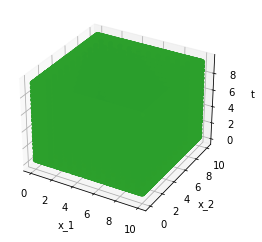

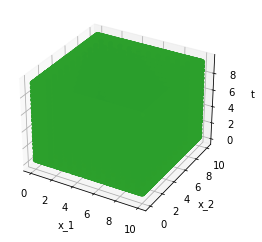

In [35]:
tp.utils.scatter(X*T, inner_sampler, initial_v_sampler, boundary_v_sampler)

In the next step we define the NN-model we want to fit to the PDE. A normalization can improve convergence for large or small domains.

In [36]:
# model with a normalization layer - in same cases it's application can be really useful to increase the convergance rate, but 
# there are also cases, where the layer does not lead to more benefit
model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_x*A_t*A_D),
    tp.models.FCN(input_space=X*T*D, output_space=U, hidden=(10,10,10))
#     tp.models.FCN(input_space=X*T*D, output_space=U, hidden=(30,30,30))
)

# model without the normalization layer
# model = tp.models.FCN(input_space=X*T*D, output_space=U, hidden=(30,30,30))


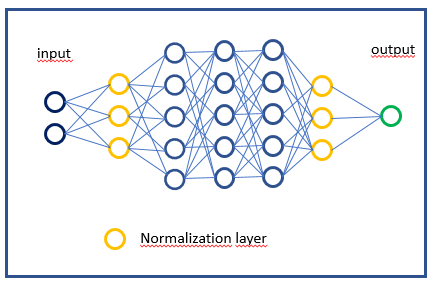

In [37]:
from IPython.display import Image
Image('NN.png',width=200, height=150)

Now, we define a condition which aims to minimze the mean squared error of the residual of the poisson equation. 

In [38]:
def heat_residual(u, x, t, D):
    return D*tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition')

Additionally, we add a boundary condition at the boundary of the domain:

In [39]:
def boundary_v_residual(u):
    return u

boundary_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=boundary_v_sampler,
                                                     residual_fn=boundary_v_residual,
                                                     name='boundary_condition')

The initial condition can be defined via a data function. Again, we minimize the mean squared error over the sampled points.

In [40]:
def f(x):
    return Tm*torch.sin(math.pi/w*x[:, :1])*torch.sin(math.pi/h*x[:,1:])

def initial_v_residual(u, f):
    return u-f

initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=initial_v_sampler,
                                                  residual_fn=initial_v_residual,
                                                  data_functions={'f': f},
                                                  name='initial_condition')

For comparison, we compute the solution via a finite difference scheme.

Comparsion to measured or computed data can be performed via a DataCondition using data supplied via a PointsDataLoader.

In [41]:
import time 

Finally, we optimize the conditions using a pytorch-lightning.LightningModule Solver and running the training. In the Solver, the training and validation conditions, as well as all optimizer options can be specified.

In [42]:
opt_setting = tp.solver.OptimizerSetting(torch.optim.AdamW, lr=1e-2) #AdamW, SGD, LBFGS
solver = tp.solver.Solver([pde_condition,
                           boundary_v_condition,
                           initial_v_condition], optimizer_setting = opt_setting)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
start = time.time()
trainer = pl.Trainer(gpus=0, # or None for CPU
                     max_steps = 200,
                     #logger=False,
                     benchmark=True,
                     log_every_n_steps=1,
                     #val_check_interval=1000,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 301   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\python\torchphysics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\python\torchphysics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [43]:
opt_setting = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-2)

solver = tp.solver.Solver([pde_condition,
                           boundary_v_condition,
                           initial_v_condition], optimizer_setting = opt_setting)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

trainer = pl.Trainer(gpus=0, # or None for CPU
                     max_steps=200,  #500 with normalization layer
                     #logger=False,
                     benchmark=True,
                     log_every_n_steps=1,
                     #val_check_interval=1000,
                     checkpoint_callback=False)
trainer.fit(solver)
end = time.time()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 301   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [44]:
print('Trainingszeit : ',(end-start)/60., ' min')

Trainingszeit :  2.138196579615275  min


Finally, we plot the obtained solution:

MovieWriter ffmpeg unavailable; using Pillow instead.


HDE_stat1.0.gif
---- Fertig ----


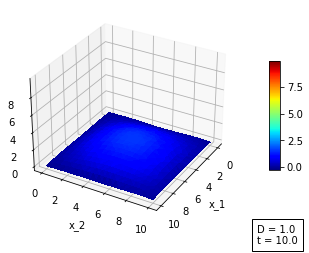

In [45]:
D_val = 1.0
anim_sampler = tp.samplers.AnimationSampler(A_x, A_t, 100, n_points=400, data_for_other_variables={'D': D_val})
anim = tp.utils.animate(model, lambda u: u[:, 0], anim_sampler, ani_speed=10)

name = 'HDE_stat'+str(D_val)+'.gif'
print(name)
anim[1].save(name)
print('---- Fertig ----')

tensor(1.5669, grad_fn=<UnbindBackward>)
tensor(-0.2637, grad_fn=<UnbindBackward>)


C:\Users\krd2rng\AppData\Local\Temp/ipykernel_8160/2823761984.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)


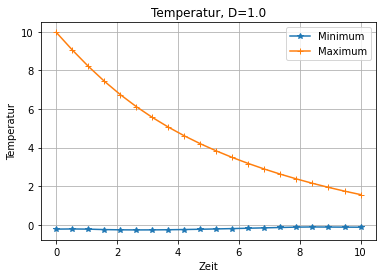

In [46]:
D_value = 1.0
time_steps = 20

grid_sampler = tp.samplers.GridSampler(A_x, n_points=128*128) + tp.samplers.GridSampler(A_x.boundary, n_points=1000)
grid_points = grid_sampler.sample_points()
D_tensor = D_value * torch.ones((len(grid_points), 1))
time_points = torch.linspace(0, tend, time_steps)
min_max_tensor = torch.zeros((time_steps, 2))

for i in range(time_steps):
    time_tensor = time_points[i] * torch.ones((len(grid_points), 1))
    eval_points = grid_points.join(tp.spaces.Points.from_coordinates({'t': time_tensor,
                                                                      'D': D_tensor}))
    model_out = model(eval_points)
    min_max_tensor[i, 0] = torch.min(model_out)
    min_max_tensor[i, 1] = torch.max(model_out)


import matplotlib.pyplot as plt
plt.plot(time_points, min_max_tensor[:, 0].detach().numpy(), marker='*')
plt.plot(time_points, min_max_tensor[:, 1].detach().numpy(), marker='+')
plt.legend(['Minimum', 'Maximum'])
plt.title('Temperatur, D=' + str(D_value))
plt.grid()
plt.xlabel('Zeit')
plt.ylabel('Temperatur')
plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)

print(min(min_max_tensor[:,1]))
print(min(min_max_tensor[:,0]))
